# Homework #3: Logistic Regression and Resampling Methods

## Background

The longevity of an athlete's career is critically important both for the individual and for the team looking to employ their efforts. Ideally, using statistics from their first season, you'd be able to determine the likelihood they'll be a solid long term investment. This dataset seeks to explore that relationship by providing first season statistics for a number of NBA players, as well as a response variable of whether they lasted in the league for 5 years or more. Our task is to use the skills we've learned in Logistic Regression to construct a model that can model this.

### Relevant Dataset

`nba_logreg.csv`

Source: https://data.world/exercises/logistic-regression-exercise-1

## Task 1: Form a training and testing dataset to be used for this analysis.
Note: Remember that we shouldn't touch the testing dataset until we're completely done with our model to ensure it's an accurate representation of the generalizability.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.metrics import accuracy_score
from collections import Counter
import numpy as np
import time
from math import exp

In [2]:
df = pd.read_csv('nba_logreg.csv')
df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [3]:
def train_test_split(df, frac=.2):
    test = df.sample(frac=frac, axis=0)
    train = df.drop(index=test.index)
    
    return test, train

In [4]:
df_test, df_train = train_test_split(df)
print(df_train.shape)
print(df_test.shape)

(1072, 21)
(268, 21)


## Task 2: Using 10-fold Cross-Validation, identify the best threshold for predicting 1 or 0 for your logistic regression model that predicts whether they will last 5 years or not given their FG% and Games Played (GP).
The easiest way to do this would probably be a double for-loop, where the outer loop iterates over a list of possible threshold values and the inner loop is your 10-fold CV. You can then plot the thresholds vs the average accuracy for each threshold.

In [5]:
splits = np.random.choice(a=3, size = df.shape[0], p = [.7,.15,.15])

In [6]:
print(splits)
print(Counter(splits))

[0 0 1 ... 1 0 0]
Counter({0: 944, 1: 220, 2: 176})


In [7]:
df_train = df.iloc[np.where(splits == 0)[0],:]
df_val = df.iloc[np.where(splits == 1)[0],:]
df_test = df.iloc[np.where(splits == 2)[0],:]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(944, 21)
(220, 21)
(176, 21)


In [8]:
thresholds = np.linspace(0,1,100)
xtrain = df_train[['FG%', 'GP']]
ytrain = df_train['TARGET_5Yrs']
log_reg = sm.Logit(ytrain, xtrain).fit()

xval = df_val[['FG%', 'GP']]
xval = pd.get_dummies(data=xval, drop_first=True)
yval = df_val[['TARGET_5Yrs']]
val_preds = log_reg.predict(xval)

acc_list = []
for thresh in thresholds:
    binary_preds = np.where(val_preds >= thresh, 1, 0)
    acc_list.append(accuracy_score(yval, binary_preds))

Optimization terminated successfully.
         Current function value: 0.610861
         Iterations 5


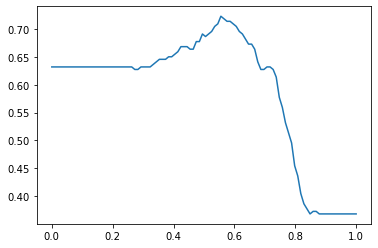

In [9]:
plt.plot(thresholds, acc_list)

In [10]:
np.argmax(acc_list)

55

In [11]:
thresholds[np.argmax(acc_list)]

0.5555555555555556

In [12]:
binary_preds = np.where(val_preds >= thresholds[np.argmax(acc_list)], 1, 0)

accuracy_score(yval, binary_preds)

0.7227272727272728

In [13]:
xtest = df_test[['FG%', 'GP']]
ytest = df_test['TARGET_5Yrs']
preds = log_reg.predict(xtest)

In [14]:
binary_preds = np.where(preds >= .8, 1, 0)

accuracy_score(ytest, binary_preds)

0.44886363636363635

In [15]:
binary_preds = np.where(preds >= thresholds[np.argmax(acc_list)], 1, 0)

accuracy_score(ytest, binary_preds)

0.6761363636363636

In [16]:
df_train_val = pd.concat([df_train, df_val])
df_train_val.reset_index(inplace=True, drop=True)

In [17]:
thresholds = np.linspace(0,1,10)
acc_list = []
folds = np.random.choice(a = 10, size = df_train_val.shape[0])

t0 = time.time()
for thresh in thresholds:
    bin_pred_list = []
    yval_list = []
    for i in range(10):
        val = df_train_val.iloc[np.where(folds == i)[0],:]
        train = df_train_val.iloc[np.where(folds != i)[0],:]
        
        xtrain = train[['FG%', 'GP']]
        ytrain = train[['TARGET_5Yrs']]
        val_preds = log_reg.predict(xval.apply(pd.to_numeric))
        
        binary_preds = np.where(val_preds >= thresh, 1, 0)
        bin_pred_list.extend(binary_preds)
        yval_list.extend(yval['TARGET_5Yrs'].tolist())
    acc_list.append(accuracy_score(yval_list, bin_pred_list))
t1 = time.time()

In [18]:
t1-t0

0.4556412696838379

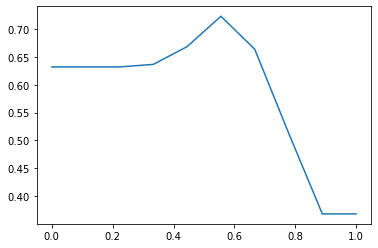

In [19]:
plt.plot(thresholds, acc_list)

In [20]:
print(thresholds[np.argmax(acc_list)])
binary_preds = np.where(preds >= thresholds[np.argmax(acc_list)],1,0)

accuracy_score(ytest, binary_preds)

0.5555555555555556


0.6761363636363636

## Task 3: Using n-fold CV, estimate the accuracy of your chosen threshold on unseen data.
This should be very similar to the previous task except your choosing the best threshold and doing n-fold CV. You should report the mean and standard deviation of your answer.

In [21]:
df_test.shape

(176, 21)

In [22]:
bin_pred_list = []
for i in range(len(df_train_val)):
    val = df_train_val.iloc[i,:].to_frame().T
    train = df_train_val.drop(index=i)
    
    xtrain = train[['FG%', 'GP']]
    ytrain = train[['TARGET_5Yrs']]
    log_reg = sm.Logit(ytrain, xtrain).fit()
    
    xval = val[['FG%', 'GP']]
    yval = val[['TARGET_5Yrs']]
    val_preds = log_reg.predict(xval.apply(pd.to_numeric))
    
    binary_preds = np.where(val_preds >= thresholds[np.argmax(acc_list)],1,0)
    bin_pred_list.append(binary_preds[0])

Optimization terminated successfully.
         Current function value: 0.606761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606570
  

         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607169
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606720
  

Optimization terminated successfully.
         Current function value: 0.606657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
  

Optimization terminated successfully.
         Current function value: 0.607115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606723
  

Optimization terminated successfully.
         Current function value: 0.606871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606551
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606543
  

Optimization terminated successfully.
         Current function value: 0.607165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607087
  

Optimization terminated successfully.
         Current function value: 0.606186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607136
  

Optimization terminated successfully.
         Current function value: 0.607071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606826
  

         Current function value: 0.606969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607180
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.607081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606068
  

Optimization terminated successfully.
         Current function value: 0.607209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607127
  

Optimization terminated successfully.
         Current function value: 0.606652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606839
  

Optimization terminated successfully.
         Current function value: 0.606925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
  

In [23]:
accuracy_score(df_train_val['TARGET_5Yrs'], bin_pred_list)

0.6735395189003437

In [24]:
thresholds = np.linspace(0,1,10)
acc_list = []

t0 = time.time()
for thresh in thresholds:
    bin_pred_list = []
    for i in range(len(df_train_val)):
        val = df_train_val.iloc[i,:].to_frame().T
        train = df_train_val.drop(index=i)

        xtrain = train[['FG%', 'GP']]
        ytrain = train[['TARGET_5Yrs']]
        log_reg = sm.Logit(ytrain, xtrain).fit()

        xval = val[['FG%', 'GP']]
        yval = val[['TARGET_5Yrs']]
        val_preds = log_reg.predict(xval.apply(pd.to_numeric))

        binary_preds = np.where(val_preds >= thresh,1,0)
        bin_pred_list.append(binary_preds[0])
    acc_list.append(accuracy_score(df_train_val['TARGET_5Yrs'], bin_pred_list))
t1 = time.time()

Optimization terminated successfully.
         Current function value: 0.606761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606570
  

Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606188
  

Optimization terminated successfully.
         Current function value: 0.606843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607157
  

Optimization terminated successfully.
         Current function value: 0.607081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606828
  

         Current function value: 0.606598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606612
         Iterations 5
Optimization termi

         Current function value: 0.607195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606951
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.606995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607170
  

Optimization terminated successfully.
         Current function value: 0.606028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607008
  

Optimization terminated successfully.
         Current function value: 0.606731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607071
  

Optimization terminated successfully.
         Current function value: 0.606444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607109
  

Optimization terminated successfully.
         Current function value: 0.607223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607103
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607085
  

Optimization terminated successfully.
         Current function value: 0.606899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605916
  

Optimization terminated successfully.
         Current function value: 0.606774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606900
  

Optimization terminated successfully.
         Current function value: 0.606808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607091
  

Optimization terminated successfully.
         Current function value: 0.607206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607221
  

Optimization terminated successfully.
         Current function value: 0.607218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606824
  

Optimization terminated successfully.
         Current function value: 0.606440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606796
  

Optimization terminated successfully.
         Current function value: 0.607138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607134
  

Optimization terminated successfully.
         Current function value: 0.607113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607056
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607098
  

Optimization terminated successfully.
         Current function value: 0.606602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606036
  

         Current function value: 0.606880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607121
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.606665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607093
  

Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607217
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606246
  

Optimization terminated successfully.
         Current function value: 0.606657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607208
  

Optimization terminated successfully.
         Current function value: 0.607073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606945
  

Optimization terminated successfully.
         Current function value: 0.606199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606829
  

Optimization terminated successfully.
         Current function value: 0.606063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
  

Optimization terminated successfully.
         Current function value: 0.606655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606147
  

Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606659
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606367
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606720
  

Optimization terminated successfully.
         Current function value: 0.606183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606657
  

         Current function value: 0.606802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607115
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.607089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606943
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606700
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607056
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606912
         Iterations 5
Optimization terminated successfully.
         Current funct

         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607136
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.607199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607114
  

Optimization terminated successfully.
         Current function value: 0.606823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607184
  

Optimization terminated successfully.
         Current function value: 0.606668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607151
  

Optimization terminated successfully.
         Current function value: 0.607154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607142
  

Optimization terminated successfully.
         Current function value: 0.606661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607205
  

Optimization terminated successfully.
         Current function value: 0.607069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606530
  

Optimization terminated successfully.
         Current function value: 0.606742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607029
  

Optimization terminated successfully.
         Current function value: 0.607184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606710
  

Optimization terminated successfully.
         Current function value: 0.606771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607112
  

Optimization terminated successfully.
         Current function value: 0.605985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606902
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606670
         Iterations 5
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.606775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607023
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606398
  

Optimization terminated successfully.
         Current function value: 0.606880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607121
  

         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607093
         Iterations 5
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: 0.607159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606738
  

Optimization terminated successfully.
         Current function value: 0.606451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606657
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606699
  

Optimization terminated successfully.
         Current function value: 0.606693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606281
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606956
  

         Current function value: 0.607140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607019
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.606883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606374
  

Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606654
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606736
  

Optimization terminated successfully.
         Current function value: 0.607136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607035
  

Optimization terminated successfully.
         Current function value: 0.607220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606857
  

         Current function value: 0.606850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606221
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.607111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606983
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607118
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607136
  

Optimization terminated successfully.
         Current function value: 0.607141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606761
  

Optimization terminated successfully.
         Current function value: 0.606665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605998
  

Optimization terminated successfully.
         Current function value: 0.607216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607008
  

Optimization terminated successfully.
         Current function value: 0.607017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606443
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607195
  

         Current function value: 0.606930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.606372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606811
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607033
  

Optimization terminated successfully.
         Current function value: 0.606868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607211
  

Optimization terminated successfully.
         Current function value: 0.606818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606916
  

Optimization terminated successfully.
         Current function value: 0.606692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607196
  

Optimization terminated successfully.
         Current function value: 0.606376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606919
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607160
  

Optimization terminated successfully.
         Current function value: 0.606963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607178
  

Optimization terminated successfully.
         Current function value: 0.607055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606523
  

Optimization terminated successfully.
         Current function value: 0.607120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606744
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606584
  

Optimization terminated successfully.
         Current function value: 0.606967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606392
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605848
  

Optimization terminated successfully.
         Current function value: 0.606945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607186
  

Optimization terminated successfully.
         Current function value: 0.606850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607217
  

Optimization terminated successfully.
         Current function value: 0.607085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607001
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606712
  

Optimization terminated successfully.
         Current function value: 0.607275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606962
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607211
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606903
  

Optimization terminated successfully.
         Current function value: 0.607178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605876
  

Optimization terminated successfully.
         Current function value: 0.607124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606887
  

Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607169
  

Optimization terminated successfully.
         Current function value: 0.606706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606599
  

Optimization terminated successfully.
         Current function value: 0.606624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606820
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607201
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607148
  

Optimization terminated successfully.
         Current function value: 0.606902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606845
  

Optimization terminated successfully.
         Current function value: 0.606783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606720
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607119
  

Optimization terminated successfully.
         Current function value: 0.606696
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606603
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607192
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607141
  

Optimization terminated successfully.
         Current function value: 0.606889
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606873
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606546
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606796
  

Optimization terminated successfully.
         Current function value: 0.607160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606693
  

Optimization terminated successfully.
         Current function value: 0.606729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607160
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
  

Optimization terminated successfully.
         Current function value: 0.607170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606248
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606938
  

Optimization terminated successfully.
         Current function value: 0.606270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607118
  

Optimization terminated successfully.
         Current function value: 0.606693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606736
  

         Current function value: 0.606233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606295
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.607059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606463
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606946
  

Optimization terminated successfully.
         Current function value: 0.606663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606974
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607065
  

Optimization terminated successfully.
         Current function value: 0.606993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606729
  

Optimization terminated successfully.
         Current function value: 0.606995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607152
  

Optimization terminated successfully.
         Current function value: 0.607176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607230
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606596
  

Optimization terminated successfully.
         Current function value: 0.606624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
  

Optimization terminated successfully.
         Current function value: 0.606783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606901
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607035
  

Optimization terminated successfully.
         Current function value: 0.606834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606934
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606922
  

         Current function value: 0.607015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606699
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607227
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.607188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607154
  

         Current function value: 0.607146
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606909
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.606063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606241
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
  

Optimization terminated successfully.
         Current function value: 0.606975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607153
  

Optimization terminated successfully.
         Current function value: 0.606774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607179
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607001
  

Optimization terminated successfully.
         Current function value: 0.606828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606656
  

Optimization terminated successfully.
         Current function value: 0.606993
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606740
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606984
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606729
  

Optimization terminated successfully.
         Current function value: 0.606635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607125
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607251
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606572
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606875
  

Optimization terminated successfully.
         Current function value: 0.607170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607087
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605891
  

Optimization terminated successfully.
         Current function value: 0.606877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607253
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606880
  

Optimization terminated successfully.
         Current function value: 0.606760
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607183
  

Optimization terminated successfully.
         Current function value: 0.606823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607182
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607215
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607184
  

Optimization terminated successfully.
         Current function value: 0.607036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607151
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606870
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607043
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606044
  

Optimization terminated successfully.
         Current function value: 0.607186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606231
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606372
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607111
  

Optimization terminated successfully.
         Current function value: 0.606868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607202
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607224
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607211
  

Optimization terminated successfully.
         Current function value: 0.607107
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606964
  

Optimization terminated successfully.
         Current function value: 0.606973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606867
  

Optimization terminated successfully.
         Current function value: 0.607082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606268
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606713
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606841
  

Optimization terminated successfully.
         Current function value: 0.607204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607138
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607199
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607220
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607157
  

Optimization terminated successfully.
         Current function value: 0.607172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607180
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607112
  

         Current function value: 0.607093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606790
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606444
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606983
         Iterations 5
Optimization termi

Optimization terminated successfully.
         Current function value: 0.607141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606690
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606761
  

Optimization terminated successfully.
         Current function value: 0.606624
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606702
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605998
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606900
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607192
  

Optimization terminated successfully.
         Current function value: 0.605876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606887
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606701
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606555
  

Optimization terminated successfully.
         Current function value: 0.606300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607221
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607223
  

Optimization terminated successfully.
         Current function value: 0.607152
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606582
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606749
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607118
  

Optimization terminated successfully.
         Current function value: 0.607034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606660
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607206
  

Optimization terminated successfully.
         Current function value: 0.606004
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606933
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606808
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606743
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607167
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.607242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606582
  

In [25]:
t1 - t0

123.40144777297974

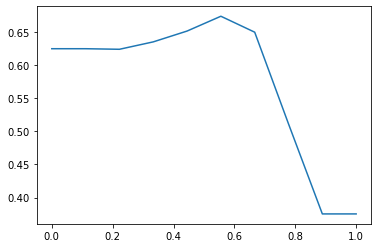

In [26]:
plt.plot(thresholds, acc_list)

In [27]:
xtest = df_test[['FG%','GP']]
ytest = df_test[['TARGET_5Yrs']]
preds = log_reg.predict(xtest)

In [28]:
binary_preds = np.where(preds >= thresholds[np.argmax(acc_list)], 1, 0)
accuracy_score(ytest, binary_preds)

0.6818181818181818

## Task 4: Using the bootstrap, get the mean and standard error of each coefficient for your logistic regression model.
Remember that the bootstrap just involves taking repeated samples from your original dataset up to the size of that dataset but with replacement. The number of samples you draw is your choice but somewhere around 11 is a fine number.

In [31]:
b0list = []
b1list = []

for i in range(11):
    boot_df = df_train_val.sample(n=df_train_val.shape[0], axis=0, replace=True)
    xtrain = boot_df[['FG%','GP']]
    ytrain = boot_df[['TARGET_5Yrs']]
    
    xtrain = sm.add_constant(xtrain)
    
    log_reg = sm.Logit(ytrain, xtrain).fit()
    
    b_0 = log_reg.params.values[0]
    b_1 = log_reg.params.values[1]
    
    b0list.append(b_0)
    b1list.append(b_1)


Optimization terminated successfully.
         Current function value: 0.577630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.566269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.572827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.595399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.565133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.550686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.572408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570351
  

In [32]:
b0list

[-3.7046685257628327,
 -5.346052453004172,
 -4.253367921275624,
 -3.517414378314888,
 -4.4598006083010295,
 -3.5909264472748483,
 -4.335343132831801,
 -4.578994094253947,
 -3.007539887920576,
 -4.1143739378775726,
 -4.4400602942755825]

In [33]:
b1list

[0.03416927287463155,
 0.06140663946200741,
 0.05104244510432227,
 0.03552103793981984,
 0.052338710752342824,
 0.03174208557985614,
 0.040153650464927484,
 0.05516859229749634,
 0.023928644894600094,
 0.04656594446453916,
 0.05116732688442842]

In [38]:
seb0 = np.sqrt((1/(len(b0list)-1))*np.sum(np.square(b0list-((1/len(b0list))*np.sum(b0list)))))

seb1 = np.sqrt((1/(len(b1list)-1))*np.sum(np.square(b1list-((1/len(b1list))*np.sum(b1list)))))

In [40]:
print('Mean of B0: ' + str(np.mean(b0list)))
print('SE of B0: ' + str(seb0))

Mean of B0: -4.12259469828117
SE of B0: 0.6363172553351849


In [41]:
print('Mean of B1: ' + str(np.mean(b1list)))
print('SE of B1: ' + str(seb1))

Mean of B1: 0.04392766824717923
SE of B1: 0.011581027312630244


## Task 5: Use your bootstrap estimates of your coefficients to predict the probability of lasting 5 years or not for your test data. If you use the threshold from before, what accuracy do you get? Is this similar to what you saw from n-fold CV?
Note: Look back at the Logistic Regression slides to see how to calculate probability.

In [47]:
prob = (2.718 ** (np.mean(b0list) + np.mean(b1list) * thresholds[np.argmax(acc_list)])) / (1 + (2.718 ** (np.mean(b0list) + np.mean(b1list) * thresholds[np.argmax(acc_list)])))
prob
# I don't think I understood this... This answer does not make sense. The accuracy should be much higher. I Think I need some help understanding this topic.

0.016338371871579677